# DQN on “FreewayDeterministic-v4"

### Imports

In [1]:
import sys
from pathlib import Path

# Add the src folder to sys.path
sys.path.append(str(Path().resolve().parent / "src"))

In [2]:
import gym
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from collections import deque
from torchvision import transforms as T

In [3]:
env = gym.make("FreewayDeterministic-v4", render_mode="rgb_array")
env.seed(0)
print("State shape: ", env.observation_space.shape)
print("Number of actions: ", env.action_space.n)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


State shape:  (210, 160, 3)
Number of actions:  3


Inspect a frame:

/home/yiannisparask/Projects/aidl-b02-task/gym-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


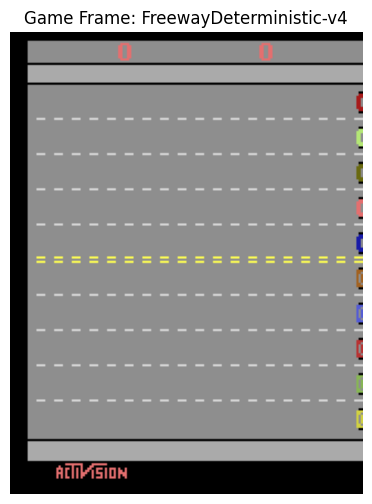

In [5]:
state, _ = env.reset()
frame = env.render()

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.axis("off") 
plt.title("Game Frame: FreewayDeterministic-v4")
plt.show()

In [4]:
def preprocess_frame(frame):
    """
    Preprocess the frame by cropping black borders, resizing, and normalizing.

    Args:
        frame (numpy.ndarray): The original frame.

    Returns:
        numpy.ndarray: The preprocessed frame.
    """
    # Convert to grayscale
    gray_frame = np.mean(frame, axis=2).astype(np.uint8)

    # Ignore the bottom 14 pixels 
    gray_frame = gray_frame[:-14, :]

    # Detect non-black regions
    non_black_indices = np.where(gray_frame > 20)

    # Find the bounding box of the non-black pixels
    y_min, y_max = np.min(non_black_indices[0]), np.max(non_black_indices[0])
    x_min, x_max = np.min(non_black_indices[1]), np.max(non_black_indices[1])

    # Crop the frame
    cropped_frame = frame[y_min : y_max + 1, x_min : x_max + 1]
    
    preprocess = T.transforms.Compose(
        [
            T.transforms.ToPILImage(),
            T.transforms.Grayscale(),
            T.transforms.Resize((80, 80)),
            T.transforms.ToTensor(),
        ]
    )
    return preprocess(cropped_frame)

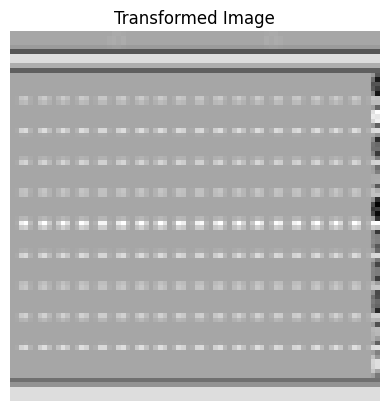

In [6]:
frame = env.render()
# Apply the transformation
transformed_img = preprocess_frame(frame)

# Display the transformed image
plt.imshow(transformed_img.permute(1, 2, 0).numpy(), cmap="gray")
plt.title("Transformed Image")
plt.axis("off")
plt.show()

In [5]:
# Frame stacking: https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/blob/master/Chapter%208/Ch8_book.ipynb

def train_agent(
    env,
    agent,
    num_episodes,
    max_timesteps, 
    frames_per_state=4,
):
    """
    Train an agent using Deep Q-Learning.
    Args:
        env: The environment.
        agent: The agent to train.
        num_episodes: The number of episodes to train for.
        max_timesteps: The maximum number of timesteps per episode.
        frames_per_state: The number of frames to stack in the state.
    Returns:
        The scores obtained during training.
    """
    scores = []
    scores_window = deque(maxlen=100)
    best_average_score = -np.inf
    patience = 10
    patience_counter = 0
    stopping_threshold = 10

    for episode in range(1, num_episodes + 1):
        state_deque = deque(maxlen=frames_per_state)
        state, _ = env.reset()
        state = preprocess_frame(state)
        for _ in range(frames_per_state):
            state_deque.append(state)
        stacked_state = torch.stack(list(state_deque), dim=1)
        episode_reward = 0
        done = False

        for _ in range(max_timesteps):
            action = agent.act(stacked_state)
            next_frame, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_frame(next_frame)
            state_deque.append(next_state)
            stacked_next_state = torch.stack(list(state_deque), dim=1)

            agent.step(stacked_state, action, reward, stacked_next_state, done)
            stacked_state = stacked_next_state
            episode_reward += reward
            if done:
                break
            
        agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)

        scores.append(episode_reward)
        scores_window.append(episode_reward)
        average_score = np.mean(scores_window)

        if episode % 50 == 0:
            print(
                f"Episode {episode}/{num_episodes}, "
                f"Average Score: {average_score:.2f}",  
            )  # f"Epsilon: {agent.epsilon:.2f}",

        if average_score >= stopping_threshold:
            if average_score > best_average_score:
                best_average_score = average_score
                patience_counter = 0  # Reset patience when improvement is found
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(
                    f"Early stopping triggered: Average score remained at {best_average_score:.2f} for {patience} episodes."
                )
                output_folder = "../model-checkpoints"
                os.makedirs(output_folder, exist_ok=True)
                print(f"Saving model in {output_folder}...")
                torch.save(
                    agent.q_network.state_dict(),
                    f"{output_folder}/freeway_dqn.pth",
                )
                break

    return scores

In [6]:
def plot_rewards(rewards):
    '''
    Plot the rewards over the episodes.
    
    Args:
    - rewards: A list of rewards.
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Training Rewards over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

Using device: cuda
Episode 50/1000, Average Score: 0.00
Episode 100/1000, Average Score: 0.04
Episode 150/1000, Average Score: 4.76
Episode 200/1000, Average Score: 11.54
Episode 250/1000, Average Score: 14.66
Episode 300/1000, Average Score: 16.72
Episode 350/1000, Average Score: 18.49
Episode 400/1000, Average Score: 19.40
Episode 450/1000, Average Score: 19.91
Episode 500/1000, Average Score: 20.29
Early stopping triggered: Average score remained at 20.42 for 10 episodes.
Saving model in ../model-checkpoints...


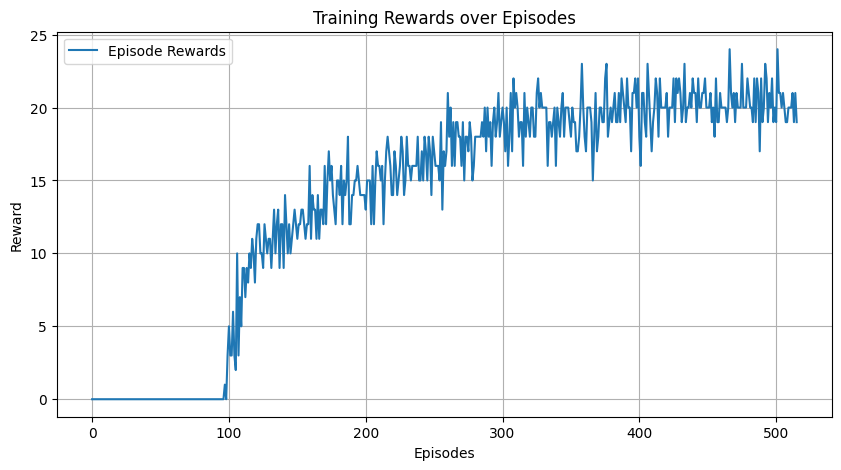

In [7]:
from agent import Agent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

state_size = env.observation_space.shape
action_size = env.action_space.n

agent = Agent(
    state_size,
    action_size,
    device,
    seed=0,
    batch_size=64,
    lr=5e-4,
    tau=5e-3,
    gamma=0.95,
    epsilon_end=0.1,
)
num_episodes = 1000
max_timesteps = 2000

scores = train_agent(env, agent, num_episodes, max_timesteps)

plot_rewards(scores)

### Inference time!

In [8]:
agent.q_network.load_state_dict(torch.load("../model-checkpoints/freeway_dqn.pth"))

/tmp/ipykernel_23085/4101902598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load("../model-checkpoints/freeway_dqn.pth"))


<All keys matched successfully>

In [17]:
os.makedirs("../videos", exist_ok=True)
video = VideoRecorder(env, "../videos/freeway_dqn.mp4", enabled=True)
state, _ = env.reset()
scores = 0
frames_per_state = 4
state_deque = deque(maxlen=frames_per_state)
for i in range(1000):
    env.render()
    video.capture_frame()
    state = preprocess_frame(state)
    for _ in range(frames_per_state):
        state_deque.append(state)
        stacked_state = torch.stack(list(state_deque), dim=1)
    action = agent.act(stacked_state)
    state, reward, done, _, _ = env.step(action)
    scores += reward
    if done:
        break
video.close()
env.close()

print(f"Score: {scores}")

Moviepy - Building video ../videos/freeway_dqn.mp4.
Moviepy - Writing video ../videos/freeway_dqn.mp4



Moviepy - Done !
Moviepy - video ready ../videos/freeway_dqn.mp4
Score: 11.0


In [18]:
from base64 import b64encode

def render_mp4(videopath: str) -> str:
    """
    Gets a string containing a b4-encoded version of the MP4 video
    at the specified path.
    """
    mp4 = open(videopath, "rb").read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return (
        f'<video width=400 controls><source src="data:video/mp4;'
        f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
    )

In [20]:
from IPython.display import HTML

html = render_mp4("../videos/freeway_dqn.mp4")
HTML(html)

## Model-based DQN